## Twitter Sentiment Analysis of Google and Apple products

### i) Business Understanding

**Business Problem**
With the growing use of social media, especially twitter, there is more information about receivability of products in the market. The company has been tasked with analysis of twitter sentiments in relation to google and apple products with an aim of meeting market demand.


**Stakeholder**

The primary stakeholders are Google and Apple's marketing department, who need to know:

*  The reception of their products in the markets
*  Which products are most liked or not
*  What about the products is lacking and how it can be improved

**Objective**
Build a classification model that can:






**Success Metrics**

*  Primary metric: F1-Score
*  Secondary metrics: Accuracy
*  ROC-AUC for model comparison

### ii) Data Understanding

The dataset is obtained CrowdFlower and can be found in this link - https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv

The data has over 9000 tweets rated by humans as either positive,negative or neither.

### iii) Importing the data and required libraries

In [189]:
#loading required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score,f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from scipy import stats
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import re
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


In [40]:
#loading the data
df = pd.read_csv("judge-1377884607_tweet_product_company.csv",encoding = 'latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [41]:
df.shape

(9093, 3)

In [42]:
## Checking for missing values
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

Tha data set has 5802 missing values under the emotion directed at column, and 1 at the tweet text column. These have to be dropped as the analysis is for google and apple oroducts, and lacking an identification of this could lead to wrong predictions.

In [43]:
#dropping missing values
df.dropna(subset=['emotion_in_tweet_is_directed_at','tweet_text'],inplace=True)

In [44]:
#checking missing values 
df.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [45]:
#checking data types
df.dtypes

tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object

In [46]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,3291,3291,3291
unique,3282,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,Positive emotion
freq,3,946,2672


In [47]:
df.value_counts()

tweet_text                                                                                                                                        emotion_in_tweet_is_directed_at  is_there_an_emotion_directed_at_a_brand_or_product
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                    Google                           Positive emotion                                      3
Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW  Android App                      Positive emotion                                      2
Before It Even Begins, Apple Wins #SXSW {link}                                                                                                    Apple                            Positive emotion                                      2
Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesom

#### Exploratory Data Analysis

In [48]:
#checking distribution of target data

df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Positive emotion                      2672
Negative emotion                       519
No emotion toward brand or product      91
I can't tell                             9
Name: count, dtype: int64

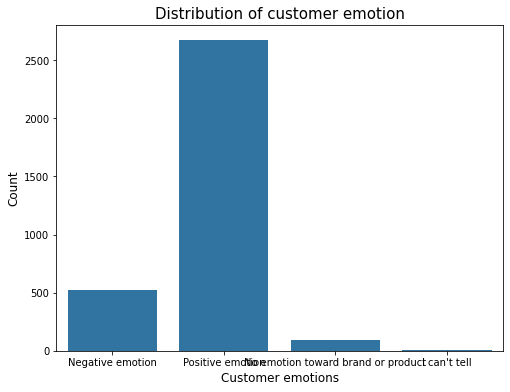

In [49]:
#visualizing distribution of target data

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df)
plt.title('Distribution of customer emotion', fontsize=15)
plt.xlabel('Customer emotions', fontsize=12)
plt.ylabel('Count', fontsize=12);

In [63]:
#feature engineering,renaming the columns for easier reference
df.rename(columns={
    'is_there_an_emotion_directed_at_a_brand_or_product':'Emotions',
    'emotion_in_tweet_is_directed_at':'Product'
},inplace=True)


In [64]:
df.head()

,tweet_text,Product,Emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### iv) Natural Language Preprocessing (NLP) 

To process the data,since its in text format,text preprocessing and vectorization are performed.

#### Text preprocessing

A pipeline has been created that converts text data to lower case for easier processing.The tweet_text column is the main focus as it contains the wording that determine the customer sentiments, hence its preprocessed.
After conversion to lower case,its tokenized, stop words are removed then stemming and lemmatization is performed.

In [98]:
def preprocess(text):
    #lowercase
    text = text.lower()
    #tokenize
    tokens = nltk.word_tokenize(text)
    #remove punctuation,numbers
    tokens = re.sub('[^a-zA-Z]','',text)
    #remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = (word for word in tokens if word not in stop_words)
    #lemmantization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    #stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    tokens = ''.join(tokens)
    return tokens

In [99]:
#applying the preprocessing steps on tweet_text
df['clean_text'] = df['tweet_text'].apply(preprocess)

In [100]:
df['clean_text'].head()

0         welehvegphneferhrweengreunweneeupgreplugnnxw
1    jeeeeknwbufluppweepphnepphulllkelpprecefregnlh...
2                          wnerlncnnwfrplhehullehewnxw
3                          xwhpeherfevlncrhherphneppxw
4    xxegreuffnfrxwrergglerellechbkcnferencepullenw...
Name: clean_text, dtype: object

### (v) Binary classification

In [114]:
#checking distribution of target data

df['Emotions'].value_counts()

Emotions
Positive emotion                      2672
Negative emotion                       519
No emotion toward brand or product      91
I can't tell                             9
Name: count, dtype: int64

The target column,Emotions,has several outputs beside the positive and negative output.As we'll begin with a binary classification,the other two will be assumed as negative.

In [115]:
df.head()

,tweet_text,Product,Emotions,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,welehvegphneferhrweengreunweneeupgreplugnnxw
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jeeeeknwbufluppweepphnepphulllkelpprecefregnlh...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wnerlncnnwfrplhehullehewnxw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,xwhpeherfevlncrhherphneppxw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,xxegreuffnfrxwrergglerellechbkcnferencepullenw...


In [121]:
mapping = {
    'Positive emotion':'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product':'Negative',
    "I can't tell": 'Negative'
}
df['Emotions_binary'] = df['Emotions'].map(mapping)
df['Emotions_binary'].value_counts()


Emotions_binary
Positive    2672
Negative     619
Name: count, dtype: int64

In [122]:
df.head()

,tweet_text,Product,Emotions,clean_text,Emotions_binary
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,welehvegphneferhrweengreunweneeupgreplugnnxw,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jeeeeknwbufluppweepphnepphulllkelpprecefregnlh...,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wnerlncnnwfrplhehullehewnxw,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,xwhpeherfevlncrhherphneppxw,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,xxegreuffnfrxwrergglerellechbkcnferencepullenw...,Positive


In [138]:
mapping1 = {
    'Positive':1,
    'Negative':0,

}
df['Emotions_binary_no'] = df['Emotions_binary'].map(mapping1)
df['Emotions_binary_no'].value_counts()

Emotions_binary_no
1    2672
0     619
Name: count, dtype: int64

In [139]:
df.head()

,tweet_text,Product,Emotions,clean_text,Emotions_binary,Emotions_binary_no
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,welehvegphneferhrweengreunweneeupgreplugnnxw,Negative,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jeeeeknwbufluppweepphnepphulllkelpprecefregnlh...,Positive,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wnerlncnnwfrplhehullehewnxw,Positive,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,xwhpeherfevlncrhherphneppxw,Negative,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,xxegreuffnfrxwrergglerellechbkcnferencepullenw...,Positive,1


### vi) Splitting data into train and test data sets

In [144]:
#split data
X = df['clean_text']
y= df['Emotions_binary_no']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [163]:
X_train

8246                  exceennheclnewrkpcewhgglecrclelnkxw
8969                   xwexpeceeverneglueherphnepelfnclue
8972    bcrhebfegnnprblelvngggleungflckngnwrngbehvrune...
1118                           lnkxwpplechlherkengexperxw
7352                   rcpnppleepenppuphpncrefxwcnlnkpple
                              ...                        
2849    nceeehepekerneknnrrelevnnrkcenbuppleclxwuhencnegn
2944    hnkennfrgvngenewpcverfrbngeupjucepckphneceunur...
3386    echnlgbefreevenbegnpplewnxwverhepweekherebeenj...
2245                                gglewebfnprexwrehwlnk
8771    hnkhevenfrncervelergphnechrgerfrnhereleennpeng...
Name: clean_text, Length: 2632, dtype: object

In [146]:
X_test

8539    njeunurrunebpplengglepeepeverechnerreeurnuphec...
8744                                 wnguehexwpplerefrpwh
4991    whenlkcrwxwevernehhewnlkngprphnenlplcewherecll...
7163    lkngfrwreengpheefhelphgrphcwherebughlerprnncrb...
4551    kenefhebhpeplefpplepevernglebhherehwherprucnph...
                              ...                        
2123           nwjxwkherefuurefrbrnenvenewppnheplnknheren
8837          juweneflnghexwrehwflrweenhnhelecfrhphnejelu
2196               pecefweenerunnrflngkulllnkennennxwrhng
2148     geekuhexwnercvepnelwhhphllergrppueurpplegeherlnk
136                              beufulxwennpplerexwpclnk
Name: clean_text, Length: 659, dtype: object

In [147]:
y_train

8246    1
8969    1
8972    1
1118    1
7352    1
       ..
2849    0
2944    1
3386    1
2245    1
8771    1
Name: Emotions_binary_no, Length: 2632, dtype: int64

In [148]:
y_test

8539    1
8744    1
4991    1
7163    1
4551    0
       ..
2123    0
8837    1
2196    1
2148    1
136     1
Name: Emotions_binary_no, Length: 659, dtype: int64

In [149]:
#checking number of columns and rows after the split to confirm working
X_train.shape

(2632,)

In [150]:
y_train.shape

(2632,)

####  Vectorization

This is done to convert the text data to numerical format to enable model interpretation.

In [152]:
#vectorize
vectorize = TfidfVectorizer()
X_train_vec = vectorize.fit_transform(X_train)
X_test_vec = vectorize.transform(X_test)

### vii) Creating,training,predicting and evaluation - logistic regression model

The first model will predict whether a customer's text represents a positive or negative emotion. It is therefore a binary classification problem, it can thus be solved by classification models/techniques. To begin we'll start with the simpler logistic regression model.

In [153]:
#model training
modellog = LogisticRegression(max_iter=1000)
modellog.fit(X_train_vec,y_train)

LogisticRegression(max_iter=1000)

In [154]:
#evaluate on testing data
trainlog_pred = modellog.predict(X_train_vec)
print(classification_report(y_train,trainlog_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       495
           1       0.81      1.00      0.90      2137

    accuracy                           0.81      2632
   macro avg       0.41      0.50      0.45      2632
weighted avg       0.66      0.81      0.73      2632



c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
#evaluate on testing data
testlog_pred = modellog.predict(X_test_vec)
print(classification_report(y_test,testlog_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       124
           1       0.81      1.00      0.90       535

    accuracy                           0.81       659
   macro avg       0.41      0.50      0.45       659
weighted avg       0.66      0.81      0.73       659



c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1 Generally from the above classification report, the recall,f1-score,precision values are zero for the negative class in both the training and testing datasets.This shows that the model is not correctly capturing / predicting negative labels. The probable cause could be an imbalance in the two classes.

2 The accuracy however is within the same range for both the training and testing dataset.

3 The positive label precision,recall and f1-score values are within range for both the training and test sets.The accuracy level therefore probably captures mostly the positive values while not correctly representing the negative values.

4 For further evaluation the ROC curve is used below to show the rate of truly predicting customers who drop off.

In [156]:
#Scikit learn's built in roc_curve returns the fpr,tpr,and threshold for various decision boundaries given the case member probabilities
#first calculate the probability scores of each of the data points

y_score = modellog.fit(X_train_vec,y_train).decision_function(X_test_vec)

#compute ROC curve values
fpr,tpr,thresholds = roc_curve(y_test,y_score)

In [157]:
#calculate AUC

auc(fpr,tpr)

0.5133026831474223

AUC: 0.5133026831474223


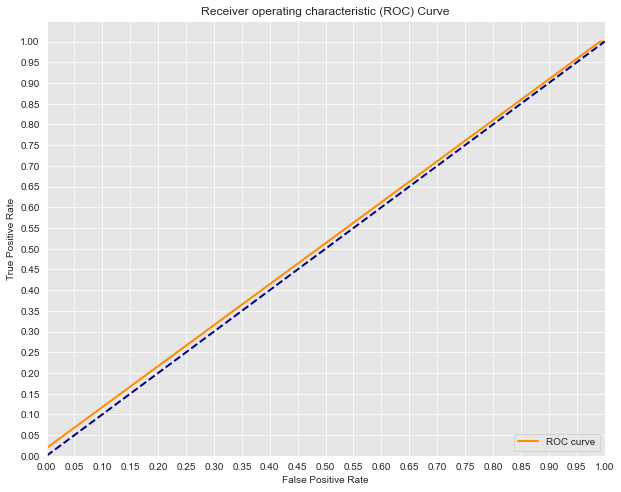

In [158]:
#plotting ROC curve
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The ROC curve above shows the model's inability to distinguish between the positive and negative classes, the ROC line is too close to the separator line(center).

A possible mishap in the dataset could be data imbalance, to solve this we'll apply smote.

#### 1) Applying SMOTE

In [164]:
# Applying SMOTE on the training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train) 
y_train_resampled.value_counts()

Emotions_binary_no
1    2137
0    2137
Name: count, dtype: int64

The result of the SMOTE technique is as shown above, the number of samples are now equal.

In [165]:
#model training
modellog_S = LogisticRegression(max_iter=1000)
modellog_S.fit(X_train_resampled,y_train_resampled)

#evaluate on training data
trainlog_pred_S = modellog_S.predict(X_train_resampled)
print(classification_report(y_train_resampled,trainlog_pred_S))


              precision    recall  f1-score   support

           0       1.00      0.82      0.90      2137
           1       0.84      1.00      0.92      2137

    accuracy                           0.91      4274
   macro avg       0.92      0.91      0.91      4274
weighted avg       0.92      0.91      0.91      4274



In [168]:
#evaluate on testing data
testlog_pred_S = modellog_S.predict(X_test_vec)
print(classification_report(y_test,testlog_pred_S))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       124
           1       0.81      1.00      0.90       535

    accuracy                           0.81       659
   macro avg       0.41      0.50      0.45       659
weighted avg       0.66      0.81      0.73       659



c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The evaluation metrics  of the balanced dataset  on the negative class have improved compared to the imbalanced dataset, they are higher.

However the model still can't classify the negative class, as seen from the zero values of the test evaluation metrics.

The model is overfitting on the training data.

In [169]:
y_score_S = modellog_S.fit(X_train_resampled,y_train_resampled).decision_function(X_test_vec)

#compute ROC curve values
fpr,tpr,thresholds = roc_curve(y_test,y_score_S)

auc(fpr,tpr)


0.5133026831474223

AUC: 0.5133026831474223


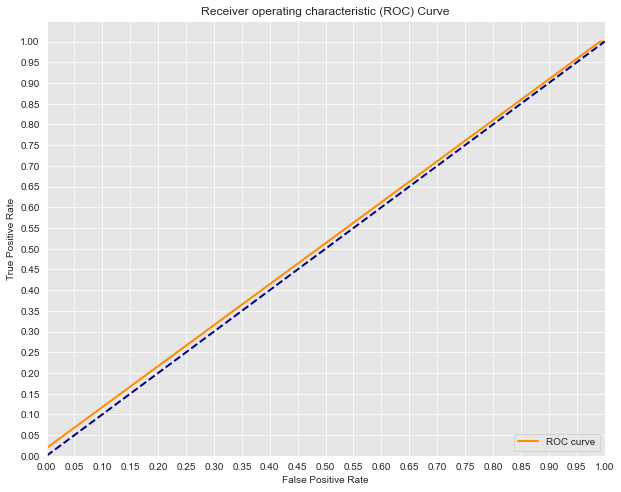

In [170]:
#plotting ROC curve
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The ROC curve after the SMOTE application is still the same.

#### 2) Hyperparameter tuning

To minimize the overfitting of the above model, we try tuning parameters to obtain a better model using GridSearchCV

In [171]:
model_h = LogisticRegression()
hyperparameters = model_h.get_params()
hyperparameters

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [183]:
#setting the hyperparameters
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga',],
    'class_weight': [None, 'balanced']
}

#initiating tuning using GrisSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1'
)

# Fitting the GridSearchCV to the data
grid_search_lr.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_lr_model = grid_search_lr.best_estimator_

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\User\anaconda3\envs\learn-env\l

In [185]:
grid_search_lr.best_params_

{'C': 100, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

In [186]:
# Generate predictions for training and test sets
y_train_pred = best_lr_model.predict(X_train_resampled)
y_test_pred = best_lr_model.predict(X_test_vec)

In [187]:
#evaluation metrics for the train data set
print(classification_report(y_train_resampled,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2137
           1       1.00      1.00      1.00      2137

    accuracy                           1.00      4274
   macro avg       1.00      1.00      1.00      4274
weighted avg       1.00      1.00      1.00      4274



In [188]:
#evaluation metrics for the test data set
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       124
           1       0.81      1.00      0.90       535

    accuracy                           0.81       659
   macro avg       0.91      0.50      0.46       659
weighted avg       0.85      0.81      0.73       659



confusion matrix plot

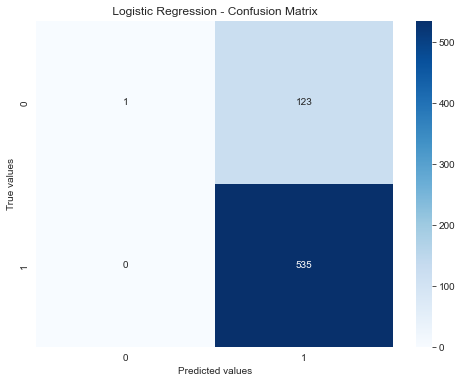

Confusion Matrix:
[[  1 123]
 [  0 535]]


In [180]:
con_mat = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues')
plt.title(' Logistic Regression - Confusion Matrix ')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.show()

print("Confusion Matrix:")
print(con_mat)

In [ ]:
TP = 535
FP = 123
TN = 1
FN = 0

The model has improved after the GridSearchCV tuning on correctly identifying true negative values with a precision of 1.However the low recall,0.01,meaning the model did not capture most of the negative values of the test data.This ultimately led to the low F1-score.

We'll try using XGboost to check for better perfomance

#### 3) Applying XGBoost

In [190]:
clf = XGBClassifier()

In [193]:
#setting the hyperparameters
param_grid_cl = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100]
}

#initiating tuning using GrisSearchCV
grid_search_cl = GridSearchCV(
    clf,
    param_grid=param_grid_cl,
    cv=5,
    scoring='f1'
)

# Fitting the GridSearchCV to the data
grid_search_cl.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_cl_model = grid_search_cl.best_estimator_

In [196]:
print(grid_search_cl.best_params_)
y_train_pred_cl = best_cl_model.predict(X_train_resampled)
y_test_pred_cl = best_cl_model.predict(X_test_vec)
print(classification_report(y_train_resampled,y_train_pred_cl))
print(classification_report(y_test,y_test_pred_cl))



{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      2137
           1       0.81      1.00      0.90      2137

    accuracy                           0.89      4274
   macro avg       0.91      0.89      0.88      4274
weighted avg       0.91      0.89      0.88      4274

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       124
           1       0.81      1.00      0.90       535

    accuracy                           0.81       659
   macro avg       0.41      0.50      0.45       659
weighted avg       0.66      0.81      0.73       659



c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


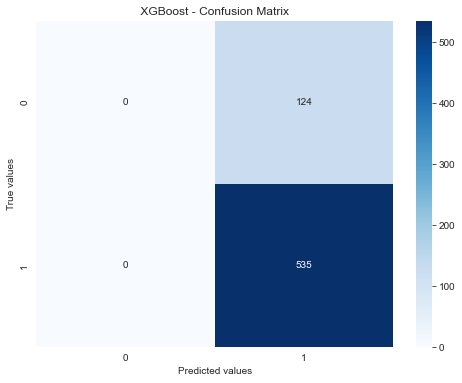

Confusion Matrix:
[[  0 124]
 [  0 535]]


In [197]:
con_mat1 = confusion_matrix(y_test, y_test_pred_cl)

plt.figure(figsize=(8, 6))
sns.heatmap(con_mat1, annot=True, fmt='d', cmap='Blues')
plt.title(' XGBoost - Confusion Matrix ')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.show()

print("Confusion Matrix:")
print(con_mat1)

The XGBoost model failed to classify the negative value leading to zero scores on recall,precision and f1-score